Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/dhruv/AirFleet-Supply-Optimizer/my-pypy-venv/lib/pypy3.11/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/0f4d42b775a445cc8abb5874a983e40b-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/0f4d42b775a445cc8abb5874a983e40b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 25 COLUMNS
At line 534 RHS
At line 555 BOUNDS
At line 628 ENDATA
Problem MODEL has 20 rows, 72 columns and 292 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 0 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)

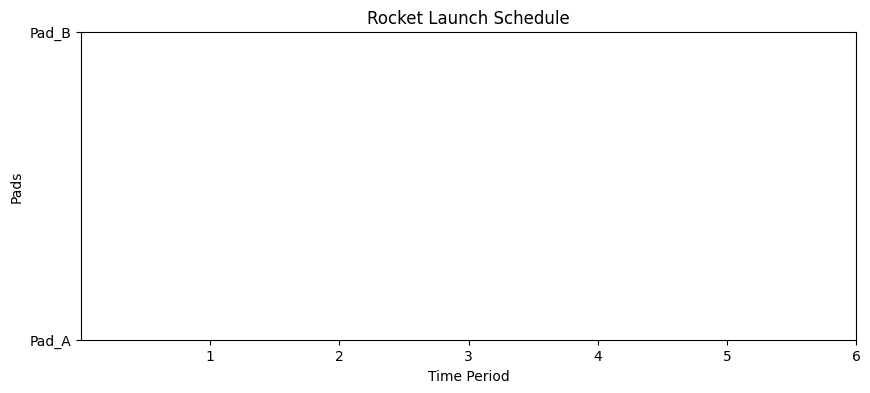

In [ ]:
import pulp as pl
import numpy as np

# --- Data ---
Rockets = ['Falcon9', 'Starship', 'Electron']
Pads = ['Pad_A', 'Pad_B']
Periods = [1, 2, 3, 4]
PrepTime = {'Falcon9': 1, 'Starship': 2, 'Electron': 1}   # periods needed for prep/fuel
FuelCost = {'Falcon9': 50, 'Starship': 100, 'Electron': 20}  # fuel per launch
LaunchCost = {'Falcon9': 100, 'Starship': 500, 'Electron': 30}
Priority = {'Falcon9': 50, 'Starship': 100, 'Electron': 20}  # higher than launch cost to make scheduling attractive
MaxFuelPerPad = {'Pad_A': 200, 'Pad_B': 150}  # total fuel limit per pad

# --- Decision variable ---
# x[r][p][t] = 1 if rocket r launches from pad p at period t
x = pl.LpVariable.dicts("Launch", (Rockets, Pads, Periods), cat='Binary')

# --- Problem ---
prob = pl.LpProblem("Rocket_Launch", pl.LpMaximize)

# --- Objective: maximize total priority score ---
prob += pl.lpSum([Priority[r]*x[r][p][t] for r in Rockets for p in Pads for t in Periods])

# --- Constraints ---

# 1. Each rocket launches at most once
for r in Rockets:
    prob += pl.lpSum([x[r][p][t] for p in Pads for t in Periods]) <= 1

# 2. Pad cannot host overlapping rockets (prep/fuel)
for p in Pads:
    for t in Periods:
        prob += pl.lpSum([x[r][p][tp] 
                         for r in Rockets 
                         for tp in range(max(1, t - PrepTime[r] + 1), t + 1)
                         if tp in Periods]) <= 1

# 3. Fuel limit per pad
for p in Pads:
    prob += pl.lpSum([FuelCost[r] * x[r][p][t] 
                     for r in Rockets 
                     for t in Periods]) <= MaxFuelPerPad

# --- Solve ---
prob.solve(pl.PULP_CBC_CMD(msg=1))

# --- Extract results ---
Assignments = {}
TotalCost = 0
TotalPriority = 0
FuelUsedPerPad = {p:0 for p in Pads}

for r in Rockets:
    for p in Pads:
        for t in Periods:
            if pl.value(x[r][p][t]) == 1:
                Assignments[r] = (p, t)
                TotalCost += LaunchCost[r]
                TotalPriority += Priority[r]
                FuelUsedPerPad[p] += FuelCost[r]

# --- Results ---
print("Assignments:", Assignments)
print("Total Launch Cost:", TotalCost)
print("Total Priority Score:", TotalPriority)
print("Fuel Used Per Pad:", FuelUsedPerPad)